# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

*Matthew Backhouse, Monica Stephanie, Ross Campbell, Royce Yan*

## General Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_actual_vs_prediction, plot_residual
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Real, Integer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Other modules that are necessary
from difflib import get_close_matches
import re
import warnings

%matplotlib inline
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
warnings.filterwarnings('ignore')

In [2]:
# Load data
data = pd.read_csv('the_office.csv')
data_guest_star = pd.read_csv('guest_duration_office.csv')

In [3]:
# Tidy up this code (Monica)
import requests
from bs4 import BeautifulSoup

# Top 50 TV Episode, Rating Count at least 1,000
url = 'https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=1000,&sort=user_rating,desc'
# Top 50 TV Episode, Rating Count at least 10,000
url2= 'https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=10000,&sort=user_rating,desc'
# Top 50 TV Episode
url3= 'https://www.imdb.com/list/ls058613627/'

def get_all_names(urls):
    episode_name,series_name=[],[]
    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        for h in soup.find_all('small', {'class': 'text-primary unbold'}):
            if h:
                episode_name.append(h.find_next_sibling('a').text)
        for h in soup.find_all('span', {'class': 'lister-item-index unbold text-primary'}):
            hh=h.find_next_sibling('a')
            if hh:
                series_name.append(hh.text)
    series_name=list(set(series_name))
    episode_name=list(set(episode_name))
    return episode_name,series_name

get_all_names((url,url2,url3))

(['The Lion and the Rose',
  'Salud',
  'Snatch Game',
  'Midnight Sun',
  'Shattered',
  'This Is Not for Tears',
  'A Scandal in Belgravia',
  'The Ricklantis Mixup',
  'ronny/lily',
  'Remedial Chaos Theory',
  'The One Where Everybody Finds Out',
  'The Rains of Castamere',
  'Vichnaya Pamyat',
  'Through the Looking Glass: Part 1',
  'Half Measures',
  'Modern Warfare',
  'The Reichenbach Fall',
  'Chapter 26',
  'Finale',
  'How Your Mother Met Me',
  "House's Head",
  'Blackwater',
  'Zero × and × Rose',
  'Ozymandias',
  'Re;',
  'Revenge Is Sweet',
  'Endgame',
  'The Phantom Apprentice',
  'Aibô',
  'The Crossing',
  'Hello, Elliot',
  'The View from Halfway Down',
  'Gliding Over All',
  'Full Measure',
  'That Day',
  'From You, 2000 Years Ago',
  "Yu Ishigami Closes His Eyes, Part 3/Miyuki Shirogane and Yu Ishigami/Kyoko Otomo Doesn't Realize",
  'Saul Gone',
  'Changing Channels',
  'Assault',
  'Three Stories',
  "Sozin's Comet, Part 3: Into the Inferno",
  'The Pirate K

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

### 2.1. Data Understanding(?)
This subsection aims to provide a more comprehend view of **data** and **data_guest_star** using `describe_data` function. The objective of this section is to identify whether any data cleansing needs to be performed on the data, e.g., fixing typo, null values imputation, etc, before feeding it into the model.

In [4]:
def describe_data(data):
    """
    Provides the data structure, sample, descriptive statistics, and unique values of the data.
    This function aims to give insights about the content of the dataset and inform users whether any data
    cleansing process needs to be done.
    
    Parameters
    ----------
    data: Raw data (pandas.DataFrame)
    
    Raises
    ------
    KeyError raised if data is empty
    """
    
    data_length = len(data)
    
    # Raising errors if data is empty
    if data_length == 0:
        raise KeyError(f'Data is empty.')
    
    print('----- Data Structure -----')
    display(data.info())
    
    print('----- Descriptive Statistics -----')
    display(data.describe())
    
    print('----- Unique Values -----')
    for col in data.columns:
        unique_vals = sorted(data[col].dropna().unique())
        length_unique_vals = len(unique_vals)
        
        if length_unique_vals <= data_length/3:
            print(f'{col} has {length_unique_vals} unique values: {unique_vals}\n')
        else:
            print(f'{col} has {length_unique_vals} unique values.\nFirst 3: {unique_vals[:3]}\nLast 3: {unique_vals[-3:]}\n')
            
    print('----- Sample: First 25 Rows -----')
    display(data.head(25))

In [5]:
describe_data(data)

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


None

----- Descriptive Statistics -----


,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,5.462366,12.478495,8.250538,2129.543011,296.397849,50.150538,3053.510753,20.693548
std,2.398464,7.233710,0.535168,790.787586,81.998568,23.941797,799.271717,5.092407
min,1.000000,1.000000,6.700000,1393.000000,131.000000,11.000000,1098.000000,12.000000
25%,3.000000,6.000000,7.900000,1628.500000,255.250000,34.000000,2670.250000,17.000000
50%,6.000000,12.000000,8.200000,1954.000000,281.000000,46.000000,2872.500000,20.000000
75%,7.750000,18.000000,8.600000,2385.000000,314.500000,60.000000,3141.000000,23.000000
max,9.000000,28.000000,9.700000,7934.000000,625.000000,166.000000,6076.000000,54.000000


----- Unique Values -----
season has 9 unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9]

episode has 28 unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

episode_name has 186 unique values.
First 3: ['A Benihana Christmas (Parts 1&2)', 'A.A.R.M', 'After Hours']
Last 3: ["Women's Appreciation", 'Work Bus', 's*x Ed']

director has 61 unique values: ['Alex Hardcastle', 'Amy Heckerling', 'Asaad Kelada', 'B.J. Novak', 'Brent Forrester', 'Brian Baumgartner', 'Bryan Cranston', 'Bryan Gordon', 'Charles McDougal', 'Charles McDougall', 'Charlie Grandy', 'Claire Scanlon', 'Claire Scanlong', 'Craig Zisk', 'Daniel Chun', 'Danny Leiner', 'David Rogers', 'Dean Holland', 'Dennie Gordon', 'Ed Helms', 'Eric Appel', 'Gene Stupnitsky;Lee Eisenberg', 'Greg Daneils', 'Greg Daniels', 'Harold Ramis', 'J.J. Abrams', 'Jason Reitman', 'Jeffrey Blitz', 'Jennifer Celotta', 'Jesse Peretz', 'John Krasinski', 'John Scott', 'Jon Favreau', 'Joss Whedon', '

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...
5,1,6,Hot Girl,Amy Heckerling,Mindy Kaling,7.8,2852,2005-04-26,346,39,3028,13,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Ryan...
6,2,1,The Dundies,Greg Daniels,Mindy Kaling,8.7,3213,2005-09-20,256,59,2812,20,Angela;Darryl;Dwight;Jim;Kelly;Kevin;Michael;O...
7,2,2,Sexual Harassment,Ken Kwapis,B.J. Novak,8.2,2736,2005-09-27,283,35,3064,26,Angela;Darryl;Dwight;Jim;Kevin;Meredith;Michae...
8,2,3,Office Olympics,Paul Feig,Michael Schur,8.4,2742,2005-10-04,281,33,2604,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
9,2,4,The Fire,Ken Kwapis,B.J. Novak,8.4,2713,2005-10-11,319,34,2766,16,Angela;Dwight;Jim;Kelly;Kevin;Meredith;Michael...


In [6]:
describe_data(data_guest_star)

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    188 non-null    int64  
 1   Season        188 non-null    int64  
 2   EpisodeTitle  188 non-null    object 
 3   About         188 non-null    object 
 4   Ratings       188 non-null    float64
 5   Votes         188 non-null    int64  
 6   Viewership    188 non-null    float64
 7   Duration      188 non-null    int64  
 8   Date          188 non-null    object 
 9   GuestStars    29 non-null     object 
 10  Director      188 non-null    object 
 11  Writers       188 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 17.8+ KB


None

----- Descriptive Statistics -----


,Unnamed: 0,Season,Ratings,Votes,Viewership,Duration
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,93.500000,5.468085,8.237234,2838.228723,7.246330,27.053191
std,54.415071,2.386245,0.589930,1063.165290,2.066012,6.937254
min,0.000000,1.000000,6.600000,1832.000000,3.250000,19.000000
25%,46.750000,3.000000,7.800000,2187.750000,5.990000,22.000000
50%,93.500000,6.000000,8.200000,2614.000000,7.535000,23.000000
75%,140.250000,7.250000,8.600000,3144.250000,8.425000,30.000000
max,187.000000,9.000000,9.800000,10515.000000,22.910000,60.000000


----- Unique Values -----
Unnamed: 0 has 188 unique values.
First 3: [0, 1, 2]
Last 3: [185, 186, 187]

Season has 9 unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9]

EpisodeTitle has 188 unique values.
First 3: ['A Benihana Christmas', 'A.A.R.M.', 'After Hours']
Last 3: ['Whistleblower', "Women's Appreciation", 'Work Bus']

About has 188 unique values.
First 3: ['A banker representing a potential buyer comes to the Scranton branch to interview the H.R. department before the sale goes through.', 'A confession at an H.R. business ethics seminar leads to a dispute between Michael and Holly over whether Meredith should be fired. Dwight tries to prove to Jim how long he can go without taking a personal break.', 'A fire in the kitchen relegates the staff to the parking lot as help is on its way.']
Last 3: ["While on lecture tour to other Dunder Mifflin branches, Michael and Pam discover that Jim's ex-girlfriend Karen is pregnant. At the office, Andy falls for a prospective client, and Jim and Dwi

,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,Director,Writers
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.20,23,24 March 2005,NaN,Ken Kwapis,Ricky Gervais |Stephen Merchant and Greg Daniels
1,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.00,23,29 March 2005,NaN,Ken Kwapis,B. J. Novak
2,2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.80,22,5 April 2005,NaN,Ken Whittingham,Paul Lieberstein
3,3,1,The Alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.40,23,12 April 2005,NaN,Bryan Gordon,Michael Schur
4,4,1,Basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.00,23,19 April 2005,NaN,Greg Daniels,Greg Daniels
5,5,1,Hot Girl,Michael is just one of the many male staff who...,7.7,3854,4.80,23,26 April 2005,Amy Adams,Amy Heckerling,Mindy Kaling
6,6,2,The Dundies,"Very much unlike his staff, an overeager Micha...",8.7,4315,9.00,21,20 September 2005,NaN,Greg Daniels,Mindy Kaling
7,7,2,Sexual Harassment,The office reviews its sexual harassment polic...,8.2,3665,7.13,22,27 September 2005,NaN,Ken Kwapis,B. J. Novak
8,8,2,Office Olympics,"Ready to finalize his deal for a new condo, Mi...",8.4,3665,8.30,22,4 October 2005,Nancy Carell,Paul Feig,Michael Schur
9,9,2,The Fire,A fire in the kitchen relegates the staff to t...,8.4,3607,7.60,22,11 October 2005,Amy Adams,Ken Kwapis,B. J. Novak


From the above information, it can be concluded that:
1. **data**
    > - **director** column has typos, e.g.: "Claire Scanlon" and "Claire Scanlong" and can be more than 1 person.
    > - **air_date** column datatype is string instead of datetime.
    > - **writer** can be more than 1 person. The column uses ";" as separator.
    > - **main_chars** are more than 1 person. The column uses ";" as separator.
<br><br>
2. **data_guest_star**
    > - **Unnamed:0** column indicates the row number and can be dropped.
    > - **GuestStars** column has null values and can be more than 1 person.
    > - **EpisodeTitle** column has slightly different values compared to **episode_name** in **data**. For example, for episode 2, episode 10, **EpisodeTitle** is "Boys and Girls" instead of "Boys & Girls" (in **data**).
    > - has more rows than **data** because episode "The Delivery" is separated into 2 parts

### 2.2. Data Cleansing
This subsection performs the following tasks:
1. **data**
    > - Fixing typo in **director** column by using `get_correct_name` function.
    > - Parse **director**, **writer**, and **main_chars** as list instead of string.
<br><br>
2. **data_guest_star**
    > - Modify the content of **EpisodeTitle** to follow **episode_name** by using `get_correct_name` function, then take the average of "The Delivery" episode.
    > - Impute null values and parse **GuestStar** as list instead of string.
    > - Remove irrelevant columns.

In [7]:
def get_correct_name(list_incorrect_words, list_correct_words):
    """
    Search for the closest match in list_correct_words to replace the incorrect word.
    This function utilizes regex and get_close_matches from difflib library.
    Reference: https://docs.python.org/3/library/difflib.html
    
    Parameters
    ----------
    list_incorrect_words: a sequence of incorrect words that needs to be replaced (list).
    list_correct_words: a sequence of correct words that will be used as the reference (list).
    
    Raises
    ------
    KeyError if either list_incorrect_words or list_correct_words is null.
    
    Returns
    -------
    corrected_words: a sequence of corrected words based on list_correct_words (pd.Series). 
    """
    
    # Raising errors if data is empty
    if len(list_incorrect_words) == 0:
        raise KeyError(f'List of incorrect words is empty.')
    elif len(list_correct_words) == 0:
        raise KeyError(f'List of correct words is empty.')
    
    list_corrected_words = []
    for word in list_incorrect_words:
        # Use regex to search whether the correct word starts with incorrect word.
        # E.g., incorrect: The Job, correct: The Job (Part 1 & 2)
        r = re.compile(f'^{word}')
        corrected_word = list(filter(r.match, list_correct_words))
        
        if len(corrected_word) != 0:
            list_corrected_words.append(corrected_word[0])
        else:
            # Find the best match using get_close_matches
            list_corrected_words.append(get_close_matches(word, list_correct_words, cutoff=0.6, n=1)[0])
        
    return list_corrected_words

In [8]:
# 1. data
# Fixing typo in director column
typo_director = ['Charles McDougal', 'Claire Scanlong', 'Greg Daneils', 'Ken Wittingham', 'Paul Lieerstein']
data_cleaned = data.copy().rename(columns={'director':'director_old'})
data_cleaned.loc[:, 'director'] = get_correct_name(data_cleaned['director_old'].values,
                                                   list(filter(lambda x: x not in typo_director, data['director'])))
data_cleaned = data_cleaned.drop(columns='director_old')

# Parse director, writer, and main_chars as list 
for col in ['director', 'writer', 'main_chars']:
    data_cleaned[col] = data_cleaned[col].str.split(';')

# 2. data_guest_star
# Modify EpisodeTitle to follow episode_name column
data_guest_star_cleaned = data_guest_star.copy().rename(columns={'EpisodeTitle':'EpisodeTitle_old'})
data_guest_star_cleaned['EpisodeTitle'] = get_correct_name(data_guest_star_cleaned['EpisodeTitle_old'].values, data['episode_name'].values)

# Impute null values in GuestStars as 'N/A'
data_guest_star_cleaned['GuestStars'] = data_guest_star_cleaned['GuestStars'].fillna('null')

# Remove irrelevant columns and take the average of "The Episode" column
data_guest_star_cleaned = data_guest_star_cleaned.groupby(['Season', 'EpisodeTitle'], as_index=False).agg({'GuestStars':'min', 'Viewership':'mean', 'Duration':'mean'})

# Parse as list
data_guest_star_cleaned['GuestStars'] = data_guest_star_cleaned['GuestStars'].str.split(',')

# Standardize column name
data_guest_star_cleaned.columns = data_guest_star_cleaned.columns.str.lower()
data_guest_star_cleaned = data_guest_star_cleaned.rename(columns={'gueststars':'guest_stars', 'episodetitle':'episode_name'})

### 2.3. Data Analysis
In this subsection, a deeper analysis about the correlation between the variables is provided.

In [9]:
def get_correlation(df):
    """
    Depicts pairwise plot and Spearman correlation matrix between numerical variables.
    
    Parameters
    ----------
    df: cleaned data that is going to be analyzed (pd.DataFrame).
    """
    
    # Pairwise plot
    sns.pairplot(df)
    
    # Phik correlation matrix
    plt.figure()
    sns.heatmap(df.corr(method='spearman'), annot=True)

In [10]:
# Merge data based on season and episode_name
if len(data_cleaned) != len(data_guest_star_cleaned):
    raise KeyError('The length of the dataframes are not equal.')
else:
    df = data_cleaned.merge(data_guest_star_cleaned, how='left', on=['season', 'episode_name'])
    df = df.drop(columns=['season', 'episode'])

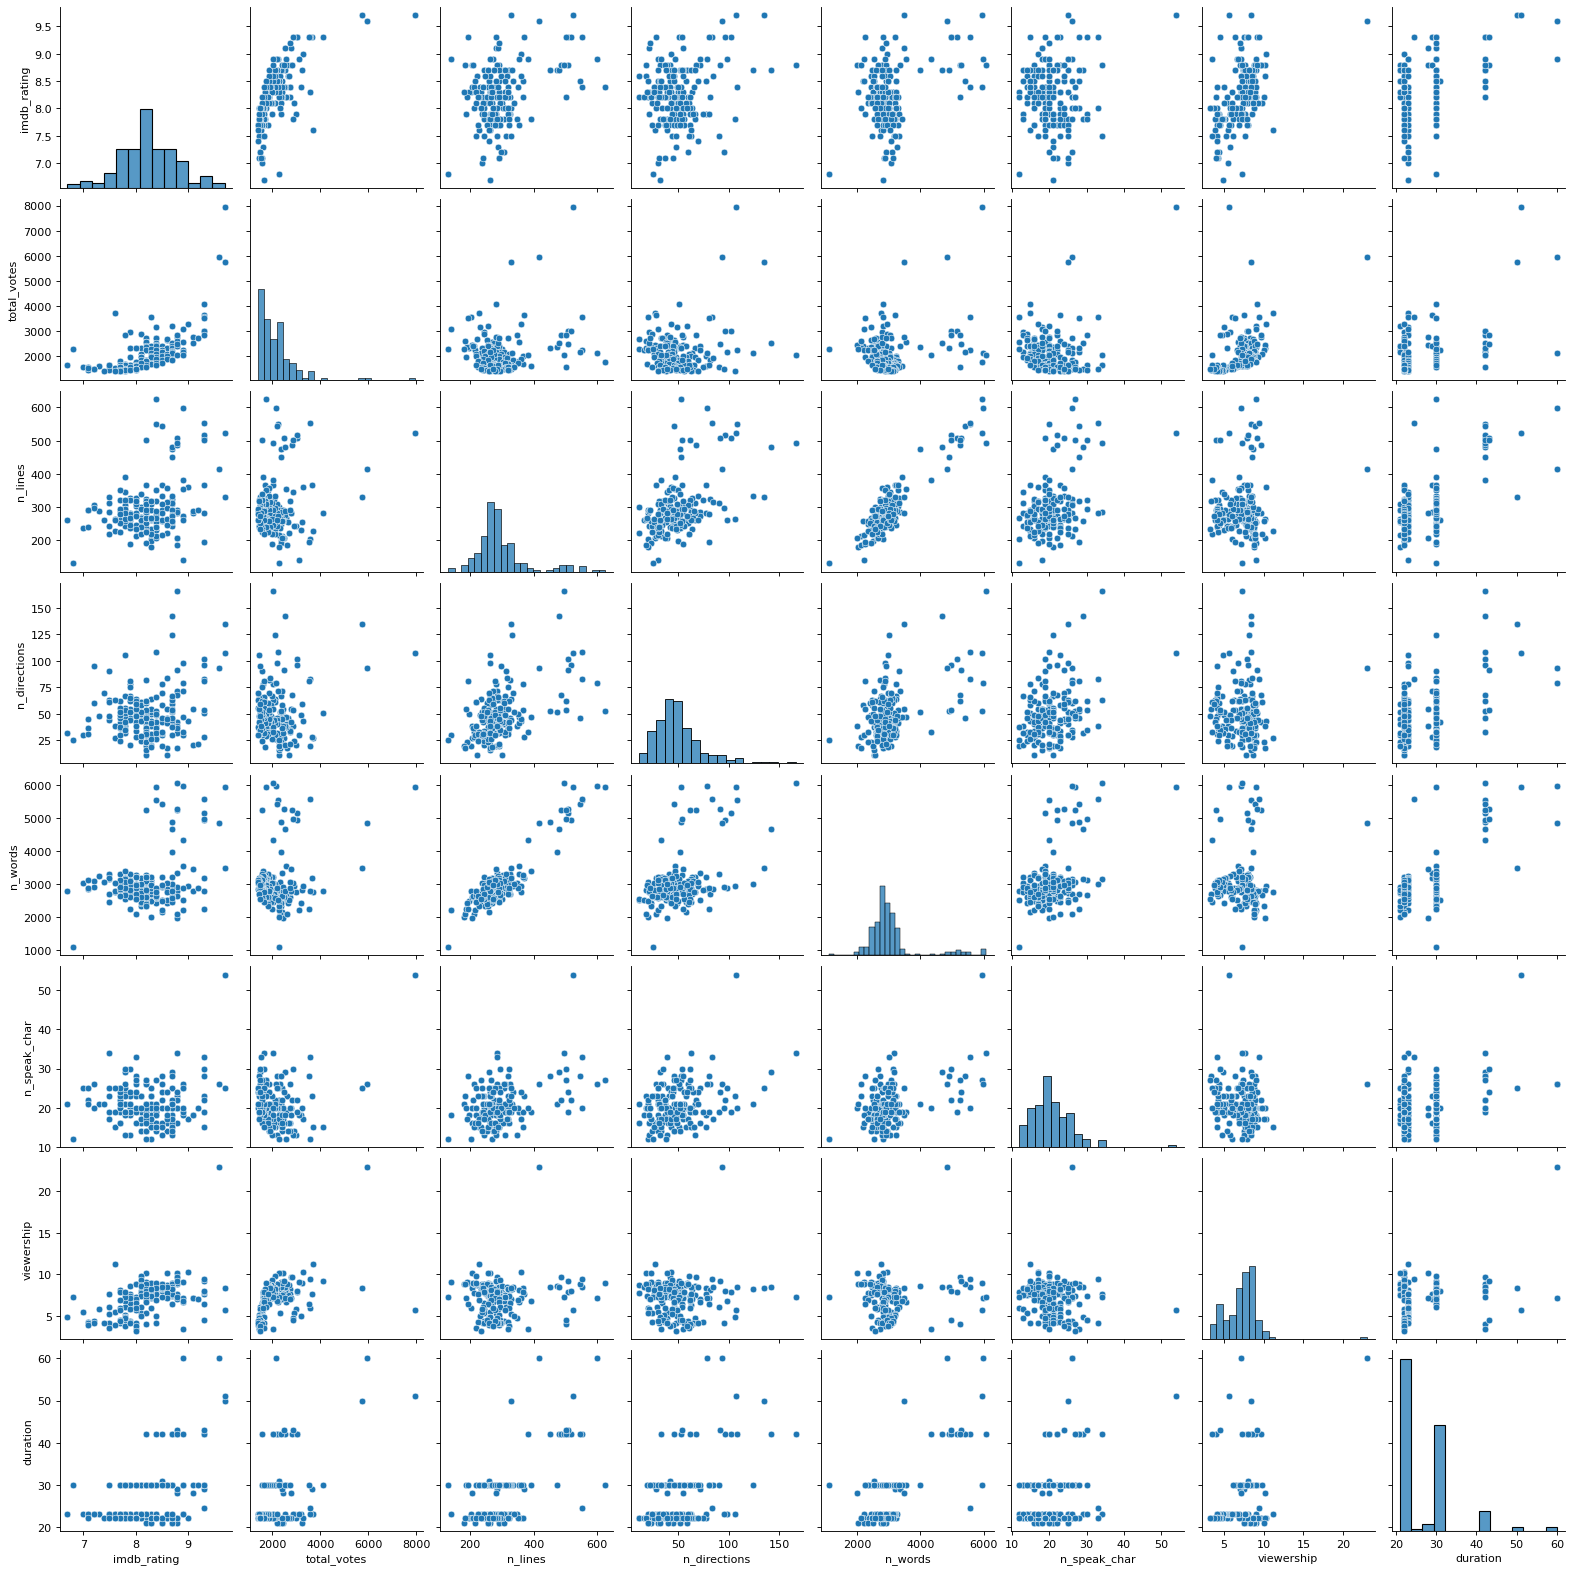

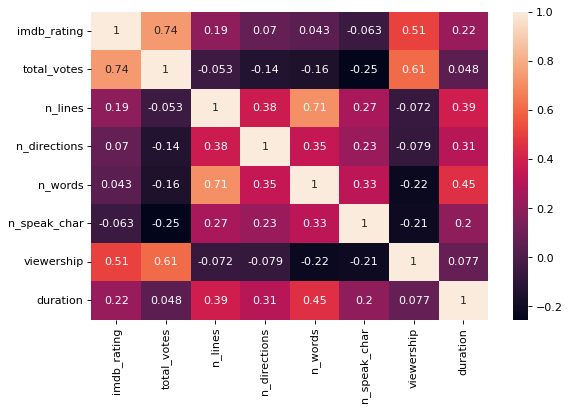

In [11]:
# Show pairwise plot and correlation matrix
get_correlation(df)

Based on the above graphs, there are several key takeaways as follows:
> - There is a very strong relationship between imdb_rating and total_votes. Additionally, there is a strong relationship between imdb_rating and viewership.
> - There is strong relationship between total_votes and viewership.
> - There is a very strong relationship between n_lines and n_words.
> - There is strong relationship between n_words and duration.

<img src="spearman_interpretation.png" width=600>

### 2.4. Feature Engineering & Selection
In this part, relevant new features are developed and features that are highly correlated or have low variance are removed.
The abovementioned features are described as follows:
1. xx 
2. xx
3. xx

In [12]:
# Count the number of writer, main_chars, and guest_stars
for col in ['writer', 'main_chars', 'guest_stars']:
    df[col + '_count'] = df[col].apply(lambda x: len(x) if x[0] != 'null' else 0)
    
# Rating and total_votes from previous episode
df['imdb_rating_prev'] = df['imdb_rating'].shift(1)

# Length of each episode name
df['episode_name_length'] = df['episode_name'].str.len()

# Writer = Director
df['same_writer_director'] = df.apply(lambda x: 1 if x['writer'] == x['director'] else 0, axis=1)

# One Hot Encoding writer, main_chars, and guest_stars
mlb = MultiLabelBinarizer()
for key, val in {'writer':'w', 'main_chars':'mc', 'guest_stars':'gs'}.items():
    mlb.fit(df[key])
    df = pd.concat([df, pd.DataFrame(mlb.fit_transform(df[key]), columns=val+'_'+mlb.classes_)], axis=1)
    
# Retrieve mean_rating, max_rating, and min_rating from writer, director, and main_chars
dictionary = {'writer': pd.DataFrame(), 'director': pd.DataFrame(), 'main_chars': pd.DataFrame()}
for col in dictionary.keys():
    dictionary[col] = (data.set_index(['air_date', 'imdb_rating']) \
                       [col].str.split(';\s*', expand=True) \
                       .stack() \
                       .reset_index() \
                       .drop(columns='level_2') \
                       .pivot_table(index=['air_date'], columns=0))
    dictionary[col] = dictionary[col]['imdb_rating'].reset_index()
    
    df[col + '_mean_rating'] = df.apply(lambda x: np.nanmean(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])),
                                        axis=1)
    df[col + '_min_rating'] = df.apply(lambda x: np.nanmin(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])) \
                                       if len(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]]) != 0 else 0,
                                        axis=1)
    df[col + '_max_rating'] = df.apply(lambda x: np.nanmax(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])) \
                                       if len(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]]) != 0 else 0,
                                        axis=1)
    
# Remove unnecessary columns
df = df.drop(columns=['episode_name', 'writer', 'air_date', 'n_directions', 'n_words', 'n_speak_char', 'main_chars',
                      'director', 'guest_stars'])

### UNFINISHED ###

In [13]:
def preprocess(num_cols, cat_cols):
    """
    Preprocess data by imputing null values and one hot encoding categorical columns.
  
    Arguments
    ---------
    impute: {'knn', 'mean', 'median', None}
            type of imputation

    scaling: {'standard', 'minmax', 'robust', None}
             type of scaling

    transform: {'yeo-johnson', 'box-cox', None}
               type of power transformer

    poly: int or None
          if int is specified, it specifies the polynomial degree

    memory: None or str
            Providing path string enables scikit-learn's pipeline caching.
            See scikit-learn pipeline documentation for more info
  
    Returns
    -------
    sklearn Pipeline
    """
    
    preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson', impute='mean'),
     num_cols),
    ('categoric', cat_pipe(encoder='onehot'),
     cat_cols)
    ])

    pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(random_state=42))
    ])
  
    return pipeline

In [14]:
def split(df):
    """
    Split data to training and testing.

    Parameters
    ----------
    df: Pandas dataframe of data to be modeled (pd.DataFrame).
    
    Returns
    -------
    X_train: Training dataset (pd.DataFrame).
    X_test: Testing dataset (pd.DataFrame).
    y_train: Training label (pd.Series).
    y_test: Testing label (pd.Series)
    """
    
    X = df.drop(columns=['imdb_rating'])
    y = df['imdb_rating']
    
    # Split out the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [15]:
def hyperparameter_tuning(pipeline, X_train, X_test, y_train, y_test):
    """
    Hyperparameter tuning using randomized search to identify the best parameters.
    
    Parameters
    ----------
    pipeline: sklearn pipeline
    X_train: Training dataset (pd.DataFrame).
    X_test: Testing dataset (pd.DataFrame).
    y_train: Training label (pd.Series).
    y_test: Testing label (pd.Series)
    
    Returns
    -------
    best_estimator: Model with best parameter (sklearn model).
    """
  
    # Run model
    # Randomized search of parameters, using 3 fold cross validation
    params = {
#               "algo__min_samples_split": Integer(2,20),
              "algo__n_estimators": Integer(100, 200),
#               "algo__max_depth": Integer(20, 80),
#               "algo__max_features": Real(0.1, 1),
#               "algo__min_samples_leaf": Integer(1, 20)
            }
    
    model = RandomizedSearchCV(pipeline, params,
                               scoring='r2', n_iter=30, random_state=42,
                               cv=3, verbose=2, n_jobs=-1)

    # Fit the randomized search model
    model.fit(X_train, y_train)
    best_estimator = model.best_estimator_
    print('Best Parameters: {}'.format(model.best_params_))
    y_pred = best_estimator.predict(X_train)
    print('R2 Score (Train): {}'.format(r2_score(y_train, y_pred)))
    # print('R2 Score (Train): {}'.format(model.best_score_))

    # Evaluation metrics
    y_pred = best_estimator.predict(X_test)
    print('R2 Score: {}'.format(r2_score(y_test, y_pred)))
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

    # Plot R2 Score and Residual
    plot_actual_vs_prediction(X_train, y_train, X_test, y_test, best_estimator)
    plot_residual(X_train, y_train, X_test, y_test, best_estimator)
  
    return best_estimator

In [16]:
def feature_importance(model, X_train, y_train):
    """
    Calculate mean score decrease (feature importance) of each feature. Mean score decrease perform a random permutation on each of the input columns then collects the score decrease caused by each columns.
  
    Parameters
    ----------
    model: Model from hyperparameter tuning (model).
    X_train: Training dataset (pd.DataFrame).
    y_train: Training label (pd.Series).
  
    Returns
    -------
    df_feature: Pandas dataframe consists of top n feature (pd.DataFrame).
    """
  
    # Check Feature Importance
    feature_importances = mean_score_decrease(X_train, y_train, best_estimator, plot=True, topk=10, normalize=True)
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)[['feature', 'importance']].reset_index(drop=True)
  
    # Show feature importance table
    display(feature_importances)

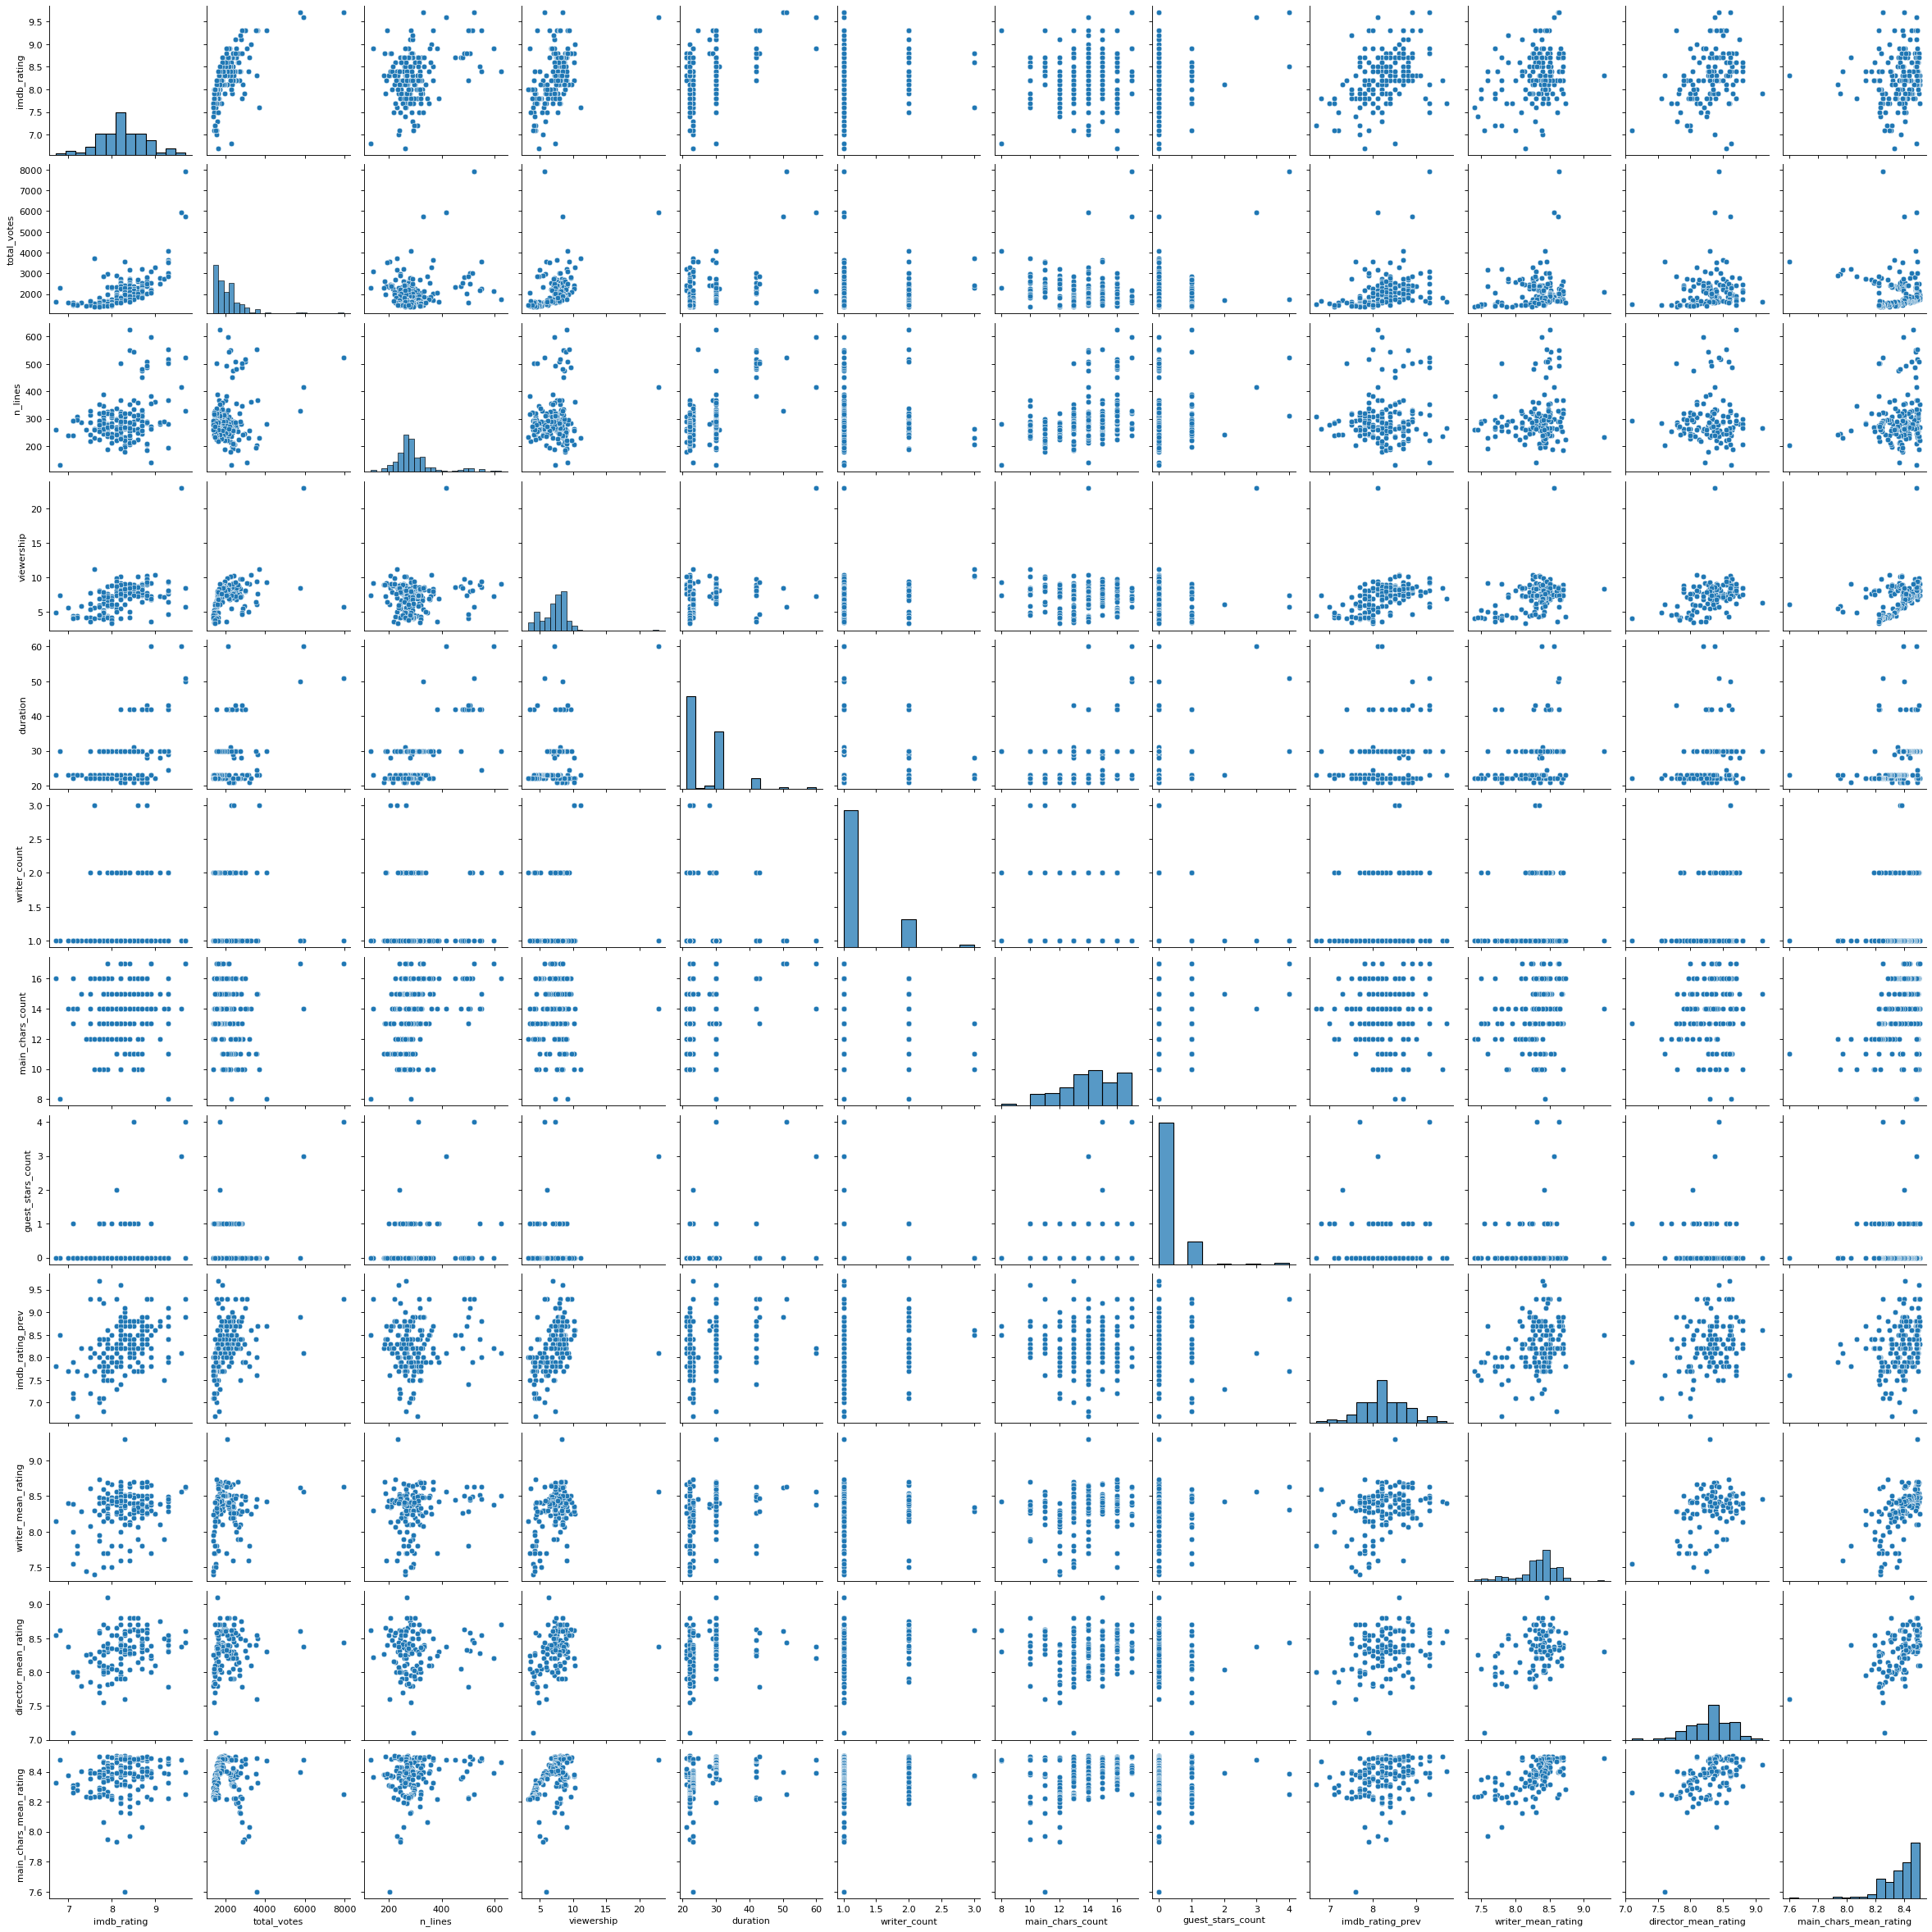

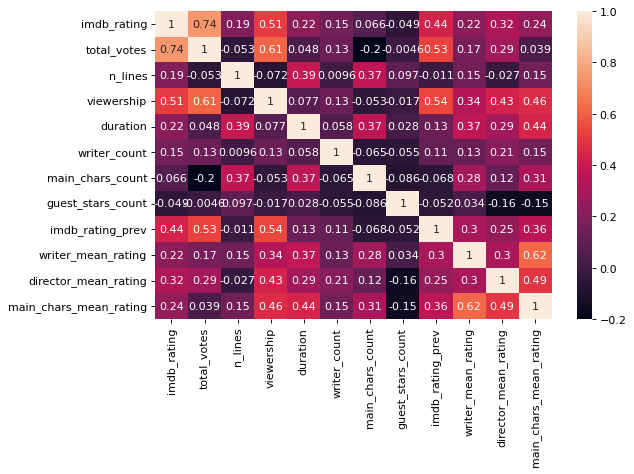

In [17]:
get_correlation(df[['imdb_rating',
 'total_votes',
 'n_lines',
 'viewership',
 'duration',
 'writer_count',
 'main_chars_count',
 'guest_stars_count',
 'imdb_rating_prev',
 'writer_mean_rating',
 'director_mean_rating',
 'main_chars_mean_rating']])

In [18]:
df.columns.to_list()

['imdb_rating',
 'total_votes',
 'n_lines',
 'viewership',
 'duration',
 'writer_count',
 'main_chars_count',
 'guest_stars_count',
 'imdb_rating_prev',
 'episode_name_length',
 'same_writer_director',
 'w_Aaron Shure',
 'w_Allison Silverman',
 'w_Amelie Gillette',
 'w_Anthony Q. Farrell',
 'w_B.J. Novak',
 'w_Brent Forrester',
 'w_Caroline Williams',
 'w_Carrie Kemper',
 'w_Charlie Grandy',
 'w_Dan Greaney',
 'w_Dan Sterling',
 'w_Daniel Chun',
 'w_Gabe Miller',
 'w_Gene Stupnitsky',
 'w_Graham Wagner',
 'w_Greg Daniels',
 'w_Halsted Sullivan',
 'w_Jason Kessler',
 'w_Jennifer Celotta',
 'w_Jon Vitti',
 'w_Jonathan Green',
 'w_Jonathan Huges',
 'w_Justin Spitzer',
 'w_Larry Willmore',
 'w_Lee Eisenberg',
 'w_Lester Lewis',
 'w_Michael Schur',
 'w_Mindy Kaling',
 'w_Nicki Schwartz-Wright',
 'w_Owen Ellickson',
 'w_Paul Lieberstein',
 'w_Peter Ocko',
 'w_Ricky Gervais',
 'w_Robert Padnick',
 'w_Ryan Koh',
 'w_Stephen Merchant',
 'w_Steve Carell',
 'w_Steve Hely',
 'w_Tim McAuliffe',
 'w

In [19]:
lol = df[['imdb_rating', 'total_votes', 'viewership',
            'writer_max_rating',
            'director_max_rating',
            'main_chars_max_rating',
            'imdb_rating_prev']].copy()

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'algo__n_estimators': 175}
R2 Score (Train): 0.9380546083037111
R2 Score: 0.6796588519522011
RMSE: 0.2502740771686598
MAE: 0.19458163265306183


,feature,importance
0,total_votes,0.780517
1,main_chars_max_rating,0.090566
2,director_max_rating,0.059065
3,viewership,0.028257
4,imdb_rating_prev,0.025981
5,writer_max_rating,0.015614


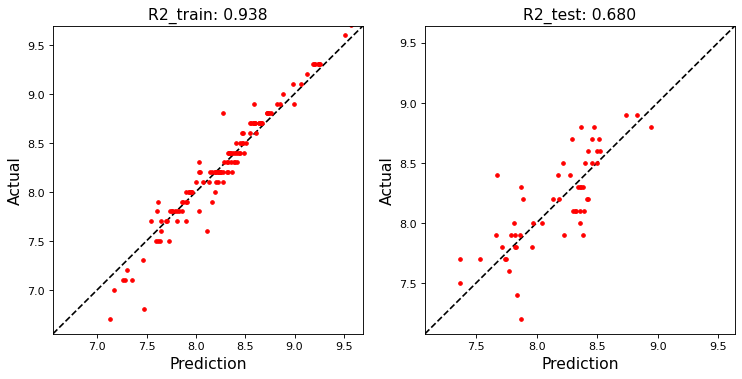

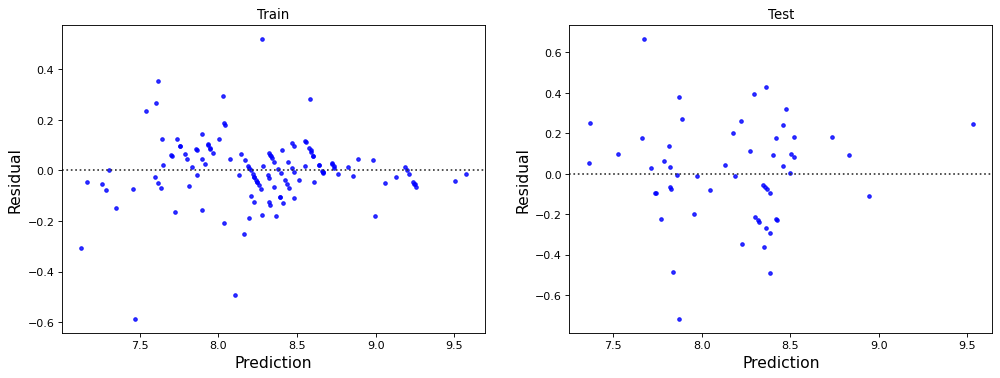

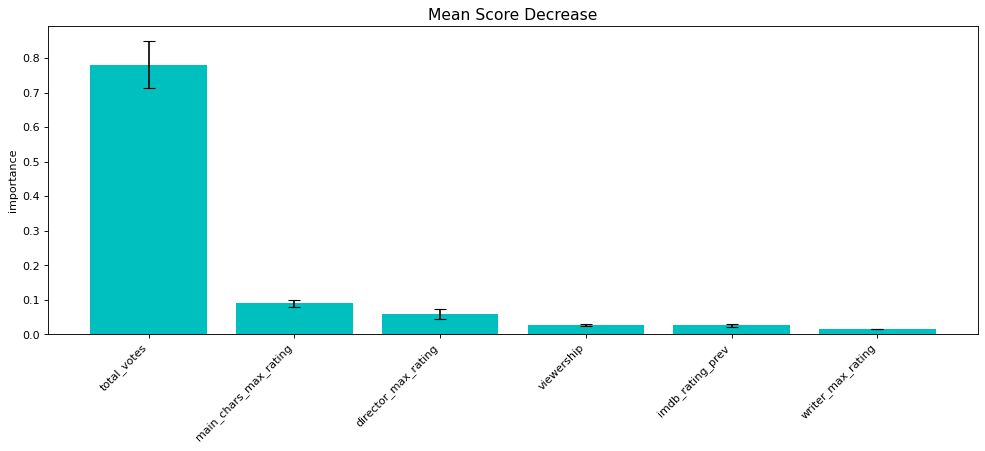

In [20]:
num_cols = ['total_votes', 'viewership', 
            'writer_max_rating',
            'director_max_rating',
            'main_chars_max_rating',
            'imdb_rating_prev']
cat_cols = []

pipeline = preprocess(num_cols, cat_cols)
X_train, X_test, y_train, y_test = split(lol)
best_estimator = hyperparameter_tuning(pipeline, X_train, X_test, y_train, y_test)
df_feature = feature_importance(best_estimator, X_train, y_train)

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from